## Face loaclization
For face loacalization we have used face_locatization library, which works preety good

In [150]:
import face_recognition
import matplotlib.pyplot as plt 
import cv2
import pandas as pd 
import numpy as np 
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import squeezenet1_0
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Image loading and face localization
image = face_recognition.load_image_file("sample.jpg",mode='L')
face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=2 ) # returns (top right bottm left)

Faces count is : 9


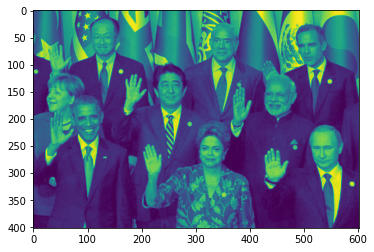

In [3]:
## Displaying image
plt.imshow(image);
print("Faces count is : {}".format(len(face_locations)))

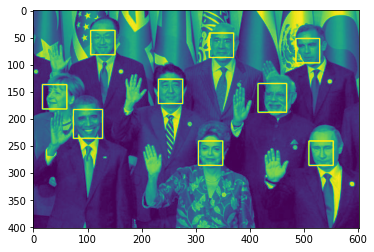

In [4]:
## plotting detected faces
for x in face_locations:
    start_point = (x[3], x[0]) 
    end_point = (x[1], x[2]) 
    color = (255, 0, 0) 
    thickness = 2
    image2 = cv2.rectangle(image, start_point, end_point, color, thickness) 
plt.imshow(image)

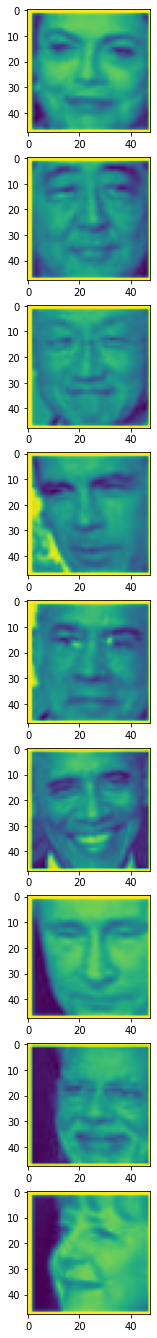

In [5]:
## Cropping all the image and displaying them
fig=plt.figure(figsize=(24, 24))
columns = 1
rows = rows=(len(face_locations))
for i,faces in enumerate(face_locations,1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.resize(image[faces[0]:faces[2],faces[3]:faces[1]],(48,48))) ## We are training data on 48*48 images
plt.show()

## Dataset Description
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.


In [6]:
index_to_emotion={
    0:'Angry', 
    1:'Disgust',
    2:'Fear', 
    3:'Happy', 
    4:'Sad', 
    5:'Surprise', 
    6:'Neutral'
}

In [7]:
dataframe = pd.read_csv('train.csv')
dataframe

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [8]:
x=dataframe.iloc[0][1]
print(len(x.split(' ')) , 48*48)
x=x.split(' ')

2304 2304


In [9]:
image=[]
iterator =[i for i in  range(0,2352,48)]
for i in range(len(iterator)-1):
    try:
        start=iterator[i]
        end=iterator[i+1]
        image.append(x[start:end])
        print(i)
    except:
        print("Error")
len(image)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


48

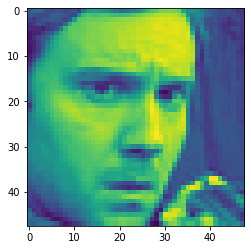

In [11]:
image = np.array(image)
image = image.astype(np.uint8)
plt.imshow(image)

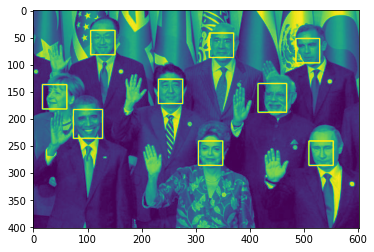

In [117]:
plt.imshow(image2)

# Model
A standered CNN calssifier is trained to predict the emotion of a face  
Model is build in pytorch

In [144]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(9216, 1000)
        self.fc2 = nn.Linear(1000, 7)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
net = ConvNet()

In [83]:
# Transforms 
transform = {
    'train':transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ]),
    'test':transforms.Compose([
        transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.Resize((48,48))
    ])
}

In [143]:
# Building dataset class
class get_dataset(Dataset):
    def __init__(self, train_test, transforms):
        self.transforms = transforms
        self.file_name = 'train.csv' if train_test == 'train' else 'test.csv'
        dataframe = pd.read_csv(self.file_name)
        self.len=len(dataframe)
        self.images = torch.zeros((len(dataframe),1,48,48))
        self.targets= torch.zeros((len(dataframe),7))
        print("Building {} dataset".format(train_test))
        for i in tqdm(range(self.len)):
            self.targets[i][dataframe.iloc[i][0]] = 1
            image_data = dataframe.iloc[i][1]
            image_data = image_data.split(' ')
            image = []
            iterator =[i for i in  range(0,2352,48)]
            for i in range(len(iterator)-1):
                start=iterator[i]
                end=iterator[i+1]
                image.append(image_data[start:end])
            image = np.array(image)
            image = image.astype(np.uint8)
            self.images[i][0]=torch.from_numpy(image)
    def __getitem__(self, index):
        if self.transforms:
            return self.transforms(self.images[i]),self.targets[i]
        else:
            return self.images[i],self.targets[i]
 
    def __len__(self):
        return self.len

In [29]:
## Creating objects of train and test datasets
train_dataset = get_dataset('train',transforms = transform['train'])
#test_dataset = get_dataset('test',transforms = transform['test'])

100%|██████████| 28709/28709 [01:36<00:00, 297.99it/s]


In [85]:
# Creating dataloader objects
print("Building train loader")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
#print("Building Test loader")
#train_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=3)

Building train loader


In [145]:
# Using Mean squared error loss
criterion = nn.MSELoss()

In [146]:
# Using SGD optimizer 
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

In [147]:
# Training model saved path and logs file name
path = 'emotion_detection.pth'
logs = 'logs.csv'

In [148]:
# Inintilizing log file
! rm logs.csv
with open(logs,'a+') as file:
    file.write('Epoch,Iteration,Loss\n')

In [149]:
for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=Variable(inputs)
        data=Variable(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        with open(logs,'a+') as file:
            file.write('{},{},{}\n'.format(epoch,i,loss.item()))
    # Saving model every epoch 
    torch.save(net.state_dict(), path)

[1,     1] loss: 0.0000717102
[1,    31] loss: 0.0020153252
[1,    61] loss: 0.0017641144
[1,    91] loss: 0.0015193506
[1,   121] loss: 0.0012724284
[1,   151] loss: 0.0010362167
[1,   181] loss: 0.0008018346
[1,   211] loss: 0.0005916505
[1,   241] loss: 0.0004123411
[1,   271] loss: 0.0002723598
[1,   301] loss: 0.0001700307
[1,   331] loss: 0.0001026421
[1,   361] loss: 0.0000621323
[1,   391] loss: 0.0000374974
[1,   421] loss: 0.0000255470
[1,   451] loss: 0.0000188498
[1,   481] loss: 0.0000146697
[1,   511] loss: 0.0000135126
[1,   541] loss: 0.0000124588
[1,   571] loss: 0.0000114238
[1,   601] loss: 0.0000117923
[1,   631] loss: 0.0000111544
[1,   661] loss: 0.0000114973
[1,   691] loss: 0.0000111942
[1,   721] loss: 0.0000109851
[1,   751] loss: 0.0000114043
[1,   781] loss: 0.0000111600
[1,   811] loss: 0.0000105474
[1,   841] loss: 0.0000113762
[1,   871] loss: 0.0000110356
[2,     1] loss: 0.0001412250
[2,    31] loss: 0.0033387334
[2,    61] loss: 0.0022394520
[2,    91]

KeyboardInterrupt: 